The Calamity roadmap will involve. 

* inverting the wedge
* performing abscal with no sky-model
* calibrating out redundancies.

In this notebook, we generate some simulations to test our methods on.

In [420]:
%matplotlib inline
import numpy as np
import healvis as hv
import healpy as hp
import matplotlib.pyplot as plt
from healvis.data import DATA_PATH
import os
import copy
from pyuvdata import UVData
from hera_cal import abscal
from hera_cal.io import HERAData, HERACal
import hera_cal.io as io
from hera_cal import apply_cal

In [424]:
uvdc = UVData()
#create layout
spacings = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ddish = 15.0
antpos = [np.array([ddish * m, 0.0, 0.0]) for m in spacings]
uvh5_data = f'simulated_array_ddish_{int(ddish)}_nant_{len(antpos)}'
uvdc.read_uvh5(uvh5_data)


antenna_diameters is not set. Using known values for HERA.


In [425]:
uvdc.data_array.shape

(45, 1, 400, 1)

In [426]:
dgrid = uvdc.data_array.squeeze()

In [427]:
from uvtools import dspec
def fft_freq(data, window='bh7'):
    w = dspec.gen_window(window, data.shape[1])
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(data * w[None,:], axes=1),axis=1),axes=1)

In [428]:
from matplotlib.colors import LogNorm

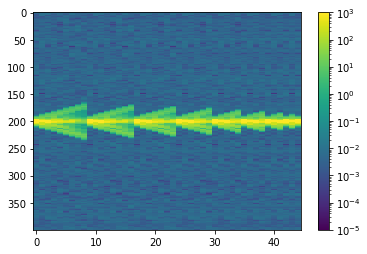

In [429]:
plt.imshow(np.abs(fft_freq(dgrid)).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

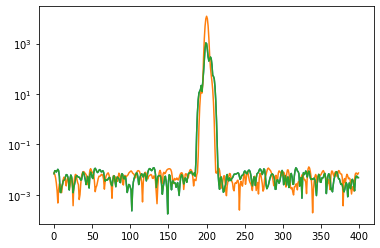

In [430]:
plt.plot(np.abs(fft_freq(dgrid))[10])
plt.plot(np.abs(fft_freq(dgrid))[0])
plt.plot(np.abs(fft_freq(dgrid))[1])


plt.yscale('log')

Try fitting to sinusoids

In [431]:
uvals = np.outer(np.linalg.norm(uvdc.uvw_array,axis=1), uvdc.freq_array[0]/3e8)
umax=uvals.max()

In [432]:
eta_max = 15. / 3e8

In [433]:
eta_max

5e-08

In [434]:
dof_freq = int(np.ceil(2 * eta_max * (uvdc.freq_array.max()-uvdc.freq_array.min())))
print(dof_freq)
dof_uv = int(np.ceil(2 * umax))
print('Number of degrees of freedom in our model:'+ str(dof_freq * dof_uv))
print('Number of measurements: '+ str(len(dgrid.flatten())))

6
Number of degrees of freedom in our model:972
Number of measurements: 18000


In [435]:
bandwidth = np.abs(uvdc.freq_array.max() - uvdc.freq_array.min())
ells = np.linspace(-1, 1, 2 * int(np.ceil(umax)), endpoint=False)
etas = np.linspace(-eta_max, eta_max, 2 * int(np.ceil(eta_max * bandwidth )))
umodes = [np.exp(-2j * np.pi * uvals * ell / (2. * umax)) for ell in ells]
etamodes = [np.exp(-2j * np.pi * uvdc.freq_array[0] * eta / (2 * bandwidth)) for eta in etas]
modes = []
for etamode in etamodes:
    for umode in umodes:
        modes.append((umode * etamode).flatten())
modes = np.asarray(modes)

In [436]:
x0 = np.array([np.dot(mode,  dgrid.flatten()) for mode in modes])

In [437]:
import scipy.optimize as op

In [438]:
modes.shape

(972, 18000)

In [439]:
res = op.lsq_linear(modes.T, dgrid.flatten())

In [440]:
mdl = modes.T @ res['x'] 

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


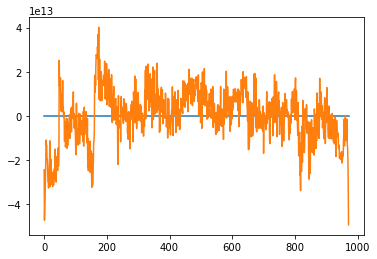

In [441]:
plt.plot(x0)
plt.plot(res['x'])

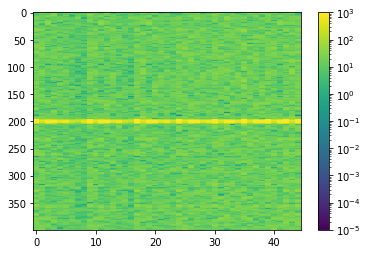

In [442]:
plt.imshow(np.abs(fft_freq(mdl.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

Looks like that failed miserably. Lets go with the array inversion, kriging approach.

In [443]:
fvals = np.asarray([uvdc.freq_array[0] for u in range(uvals.shape[0])])

In [444]:
ugx, ugy = np.meshgrid(uvals, uvals)
fx, fy = np.meshgrid(fvals, fvals)
cov_fg = 1e8 * np.sinc(2 * (ugx - ugy) ) * np.sinc(2 * eta_max * (fx - fy))

In [445]:
cov_tot = np.identity(len(uvals.flatten())) + cov_fg
fg_fit_operator = cov_fg @ np.linalg.inv(cov_tot)

In [446]:
mdl = (fg_fit_operator @ dgrid.flatten()).reshape(dgrid.shape)

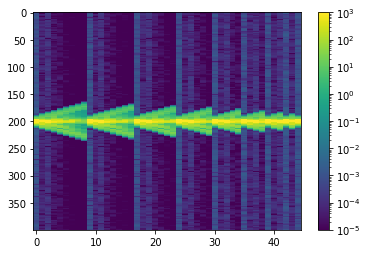

In [447]:
plt.imshow(np.abs(fft_freq(mdl.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

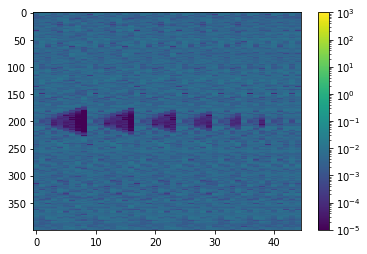

In [448]:
plt.imshow(np.abs(fft_freq(dgrid-mdl.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

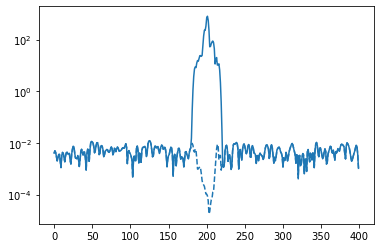

In [449]:
l0=plt.plot(np.abs(fft_freq(dgrid))[12])[0]
plt.plot(np.abs(fft_freq(dgrid-mdl)[12]), color=l0.get_color(), ls='--')
#l0=plt.plot(np.abs(fft_freq(dgrid))[0])[0]
#plt.plot(np.abs(fft_freq(dgrid-mdl)[0]), color=l0.get_color(), ls='--')
#l0=plt.plot(np.abs(fft_freq(dgrid))[1])[0]
#plt.plot(np.abs(fft_freq(dgrid-mdl)[1]), color=l0.get_color(), ls='--')

plt.yscale('log')

Lets try using the principal components of the fg covariance to do the fit.

In [450]:
evals, evecs = np.linalg.eigh(cov_tot)

We see that the number of degrees of freedom is more like around 7500 for this basis. Perhaps this is because the 

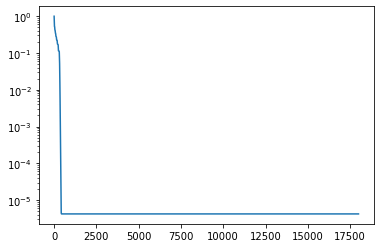

In [451]:
plt.plot(np.sqrt(evals[::-1]/evals.max()))
plt.yscale('log')

In [452]:
to_fit = np.sqrt(evals / evals.max()) >= 1e-5

In [453]:
evecs.shape

(18000, 18000)

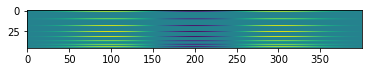

In [454]:
plt.imshow(evecs[:,-10].reshape(dgrid.shape))

In [455]:
evecs[to_fit].shape

(408, 18000)

In [456]:
res_dy = op.lsq_linear(evecs[:, to_fit], dgrid.flatten())

Because vectors are already orthonormal, we can just take dot products without doing the whole rigamaroll of lsq linear fitting.

In [457]:
mdl_dy = res_dy['x'] @ evecs[:,to_fit].T


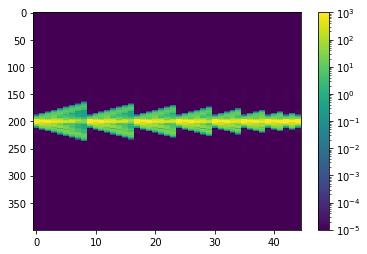

In [458]:
plt.imshow(np.abs(fft_freq(mdl_dy.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-5,1e3))
plt.colorbar()

An abscal recipe

* compute  $\left\{\hat{f}_k^0 \right\}$ by taking dot products of eigenvectors with data.
* solve for a first guess at $\hat{G}(\nu)$ by solving \begin{equation} \log(G(\nu)) = \log(V) - \log(M) \end{equation} where $V$ are the measured visibilities and $M$ is the model from our dot product.
* Apply $G$ and solve for next guess of $M$. 
* Repeate with loop $\log(G^m) = \log(V) - \log(M^{m})$ and $M^{m} = \Lambda^T \Lambda V (V / G^{m-1})$

We already have all the code we need to solve for G given an M in the abscal package!

So basically, all we have to do is solve for $\{f_k^n\}$, then use this as a model to solve for $\hat{G}^n$.

In [612]:
uvdc_gain_errors = copy.deepcopy(uvdc)
gain = 1. + 1 * np.exp(2j * np.pi * hd_gain_errors.freq_array[0] * 200e-9) + np.exp(2j * np.pi * hd_gain_errors.freq_array[0] * 1000e-9)
uvdc_gain_errors.data_array *= gain[None, None, :, None]
hd_gain_errors = io.to_HERAData(uvdc_gain_errors)

In [613]:
def generate_model_from_basis(fit_operator, hd):
    hdt = copy.deepcopy(hd)
    model = np.zeros_like(hdt.data_array)
    nbl = hdt.Nbls
    for t in range(hdt.Ntimes):
        for p in range(hdt.Npols):
            model[nbl * t: nbl * (t+1), :, :, p] = (fit_operator\
            @ (hd.data_array[nbl * t: nbl * (t+1), 0, :, p]).reshape((fit_operator.shape[1],))).reshape(hd.Nbls, 1, hd.Nfreqs)
    hdt.data_array = model
    model_data, _, _ = hdt.build_datacontainers()
    return model_data
    

In [614]:
hd_temp = copy.deepcopy(hd_gain_errors)
model = generate_model_from_basis(fg_fit_operator,hd_temp)
data,_,_ = hd_temp.build_datacontainers()

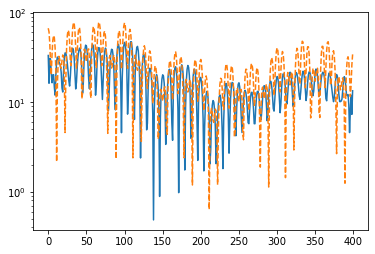

In [615]:
plt.plot(np.abs(model[(1,3,'xx')][0]-data[(1,3,'xx')][0]))
plt.plot(np.abs(data[(1,3,'xx')][0]), ls='--')
plt.yscale('log')

In [616]:
np.unique(np.hstack([hd_temp.ant_1_array, hd_temp.ant_2_array]))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [617]:
dgrid.sum()

(-396599.0294948626+73051.20963224025j)

In [783]:
def calamity_loop(fitting_operator, hd, hdskymodel, niter=2, delta=0.3):
    '''
    fitting_operatre : an (Nbl x Nfreq) x (Nbl x Nfreq) operator that returns a fg model from the data
                       for our purposes, we will use a 
    '''
    m = 0
    ants = np.unique(np.hstack([hd_temp.ant_1_array, hd_temp.ant_2_array]))
    hdt = copy.deepcopy(hd)
    hdm = copy.deepcopy(hd)
    last_gain = 0
    abscal_gain = 9e99
    skymodel, _, _ = hdskymodel.build_datacontainers()
    while m<niter:
        model = generate_model_from_basis(fitting_operator, hdt)
        # normalize sum over all data points.
        model_amp = 1 
        model_pha = 0.
        nratio = 0
        model_ratio = 0.+0j
        for k in model:
            model_ratio += np.mean(model[k]/skymodel[k])
            nratio += 1
        model_ratio /= nratio
        model = model / model_ratio
        # run abscal on model
        data, flags, nsamples = hd.build_datacontainers()
        # set up linsolve system
        abscal_gain = np.sum(np.asarray([data[k] * np.conj(model[k]) for k in data]), axis=0)\
        / np.sum(np.asarray([np.abs(model[k]) ** 2. for k in data]), axis=0)
        gprime = {(ant, 'Jxx'): abscal_gain for ant in ants}
        if m == 0:
            gains = gprime
        else:
            delta_gains = {k: gprime[k] - gains[k] for k in gains}
            gains = {k: (1-delta) * gains[k] + delta * delta_gains[k] for k in gains}
 
        # update calibrated data
        data = {k: data[k] / gains[(k[0], 'Jxx')] for k in data}
        hdt.update(data=data)
        hdm.update(data=model)
        m+=1
        # repeate
    return hdt, gains, hdm
    

In [776]:
gains.keys()

dict_keys([5, 10, 50])

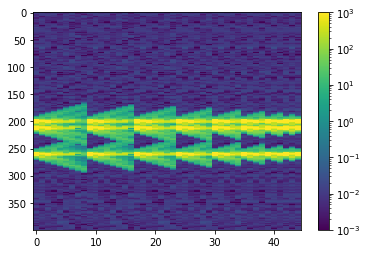

In [777]:
plt.imshow(np.abs(fft_freq(uvdc_gain_errors.data_array.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-3,1e3))
plt.colorbar()

In [784]:
calibrated_data = {}
gains = {}
calibrated_model = {}
dnorm = uvdc.get_data(0,1,'xx')[0,0]
for iters in [5, 10, 50]:
    calibrated_data[iters], gains[iters], calibrated_model[iters] = calamity_loop(fitting_operator=fg_fit_operator, delta=0.3,
                                           hd=hd_gain_errors, hdskymodel=io.to_HERAData(uvdc), niter=iters)

In [730]:
def fftbh(x):
    w = dspec.gen_window('bh', len(x))
    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(w * x)))

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


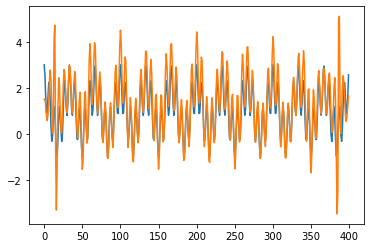

In [731]:
dlys = np.fft.fftshift(np.fft.fftfreq(hd_gain_errors.Nfreqs, np.mean(np.diff(hd_gain_errors.freq_array)))) * 1e9
plt.plot(gain)
plt.plot(gains[10][(1,'Jxx')][0])
#plt.yscale('log')
#plt.xlim(150,250)
#plt.ylim(1e-5,4e2)
#plt.xlim(-1400,1400)
#plt.axvline(15. * 10 / .3, ls='--', color='k')
#plt.axvline(-15. * 10 / .3, ls='--', color='k')

Text(0.5, 1.0, 'Gain Solutions')

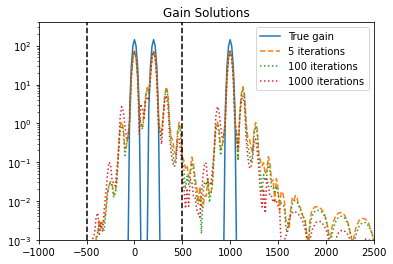

In [785]:
dlys = np.fft.fftshift(np.fft.fftfreq(hd_gain_errors.Nfreqs, np.mean(np.diff(hd_gain_errors.freq_array)))) * 1e9
plt.plot(dlys, np.abs(fftbh(gain)), label='True gain')
plt.plot(dlys, np.abs(fftbh(gains[5][(1,'Jxx')][0])), ls='--', label='5 iterations')
plt.plot(dlys, np.abs(fftbh(gains[10][(1,'Jxx')][0])), ls=':', label='100 iterations')
plt.plot(dlys, np.abs(fftbh(gains[50][(1,'Jxx')][0])), ls=':', label='1000 iterations')

plt.yscale('log')
#plt.xlim(150,250)
plt.ylim(1e-3,4e2)
plt.xlim(-1000,2500)
plt.axvline(15. * 10 / .3, ls='--', color='k')
plt.axvline(-15. * 10 / .3, ls='--', color='k')
plt.legend()
plt.title('Gain Solutions')

Casting complex values to real discards the imaginary part


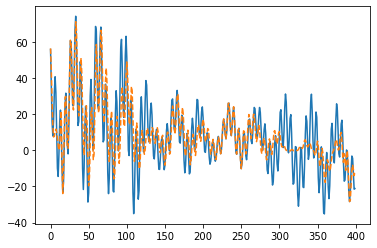

In [786]:
datage, _ , _ = hd_gain_errors.build_datacontainers()
mdata, _, _ = calibrated_model[10].build_datacontainers()
cdata, _, _ = calibrated_data[10].build_datacontainers()

#plt.plot(np.imag(mdata[(1,3,'xx')][0]*gains[10][(1, 'Jxx')][0]))
plt.plot(np.imag(datage[(1,3,'xx')][0]))
plt.plot(np.imag(cdata[(1,3,'xx')][0]) * gains[10][(0,'Jxx')][0], ls='--')

#plt.plot(np.abs(data[(1,3,'xx')][0]), ls='--')
#plt.yscale('log')

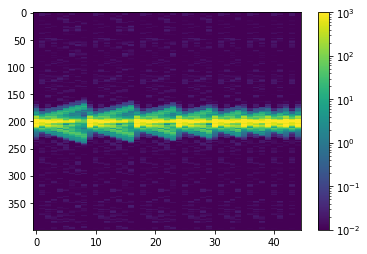

In [787]:
plt.imshow(np.abs(fft_freq(calibrated_data[10].data_array.reshape(dgrid.shape))).T, interpolation='nearest', aspect='auto',
           norm=LogNorm(1e-2,1e3))
plt.colorbar()

Here is some food for thought.

The calibrated data no longer has foregrounds at high delays

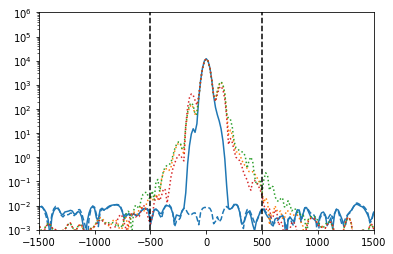

In [809]:
bl=44
l0=plt.plot(dlys, np.abs(fft_freq(dgrid))[bl])[0]
plt.plot(dlys, np.abs(fft_freq(dgrid-mdl)[bl]), color=l0.get_color(), ls='--')
plt.plot(dlys, np.abs(fft_freq(calibrated_data[10].data_array.reshape(dgrid.shape))[bl]/2), ls=':')
plt.plot(dlys, np.abs(fft_freq(calibrated_data[5].data_array.reshape(dgrid.shape))[bl]/2), ls=':')
plt.plot(dlys, np.abs(fft_freq(calibrated_data[50].data_array.reshape(dgrid.shape))[bl]/2),ls=':')

#l0=plt.plot(np.abs(fft_freq(dgrid))[0])[0]
#plt.plot(np.abs(fft_freq(dgrid-mdl)[0]), color=l0.get_color(), ls='--')
#l0=plt.plot(np.abs(fft_freq(dgrid))[1])[0]
#plt.plot(np.abs(fft_freq(dgrid-mdl)[1]), color=l0.get_color(), ls='--')
plt.axvline(15. * 10 / .3, ls='--', color='k')
plt.axvline(-15. * 10 / .3, ls='--', color='k')
plt.xlim(-1500,1500)
plt.ylim(1e-3, 1e6)
plt.yscale('log')